## Import the necesssary library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read the dataset

In [2]:
df = pd.read_csv('Amazon Product Review.csv')
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1


## statistical analysis

In [3]:
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes,sentiment
count,3.084600e+04,30846.0,30846.000000,30846.00000,30846.000000,30846.000000
mean,2.471002e+07,2693241.0,4.336154,0.68641,0.895027,0.835343
std,1.611172e+07,0.0,1.120716,30.74337,32.356354,0.370876
min,1.134600e+04,2693241.0,1.000000,0.00000,0.000000,0.000000
25%,1.150637e+07,2693241.0,4.000000,0.00000,0.000000,1.000000
50%,2.294025e+07,2693241.0,5.000000,0.00000,0.000000,1.000000
75%,4.008874e+07,2693241.0,5.000000,0.00000,0.000000,1.000000
max,5.309351e+07,2693241.0,5.000000,3720.00000,3875.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30846 entries, 0 to 30845
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marketplace        30846 non-null  object
 1   customer_id        30846 non-null  int64 
 2   review_id          30846 non-null  object
 3   product_id         30846 non-null  object
 4   product_parent     30846 non-null  int64 
 5   product_title      30846 non-null  object
 6   product_category   30846 non-null  object
 7   star_rating        30846 non-null  int64 
 8   helpful_votes      30846 non-null  int64 
 9   total_votes        30846 non-null  int64 
 10  vine               30846 non-null  object
 11  verified_purchase  30846 non-null  object
 12  review_headline    30844 non-null  object
 13  review_body        30842 non-null  object
 14  review_date        30846 non-null  object
 15  sentiment          30846 non-null  int64 
dtypes: int64(6), object(10)
memory usage: 3.

In [5]:
#To check the shape of the data
df.shape

(30846, 16)

In [6]:
#to drop the NaN values
df.dropna(inplace = True)

## Exploratory Data Analysis

In [7]:
#To count the number of each rating

df['star_rating'].value_counts()

star_rating
5    20017
4     5746
3     2216
1     1707
2     1154
Name: count, dtype: int64

Text(0, 0.5, 'Count')

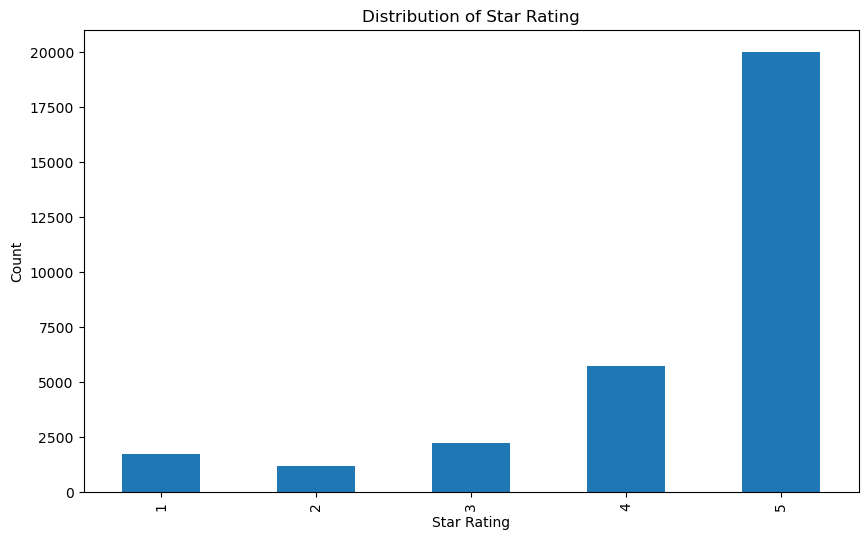

In [8]:
#To visualize the distribution of the rating
plt.figure(figsize = (10,6))
df["star_rating"].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Count')

In [9]:
df['sentiment'].value_counts()

sentiment
1    25763
0     5077
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of the sentiment value')

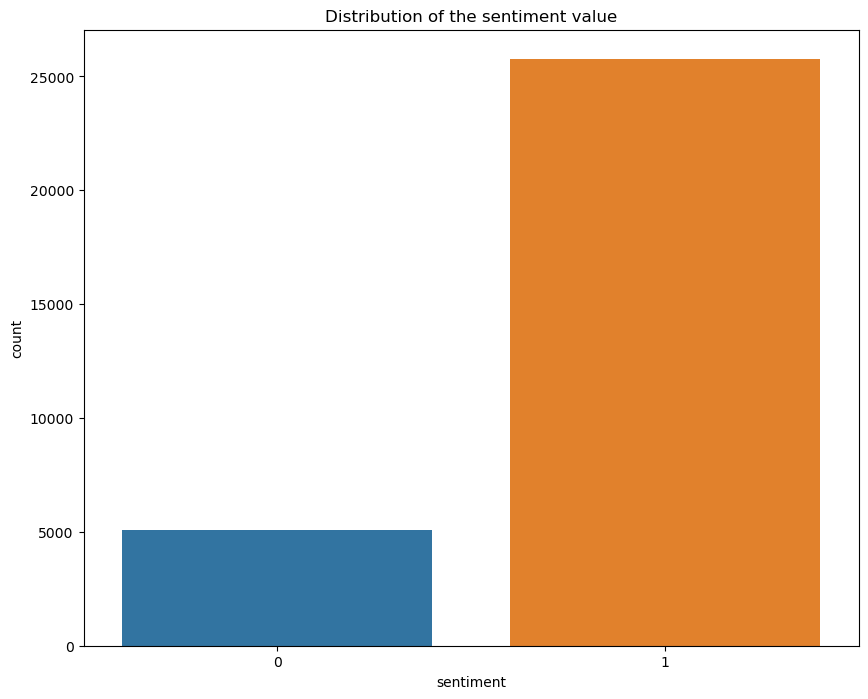

In [10]:
#Plotting avg number of words in negative and positive reviews to see the distribution of sentiment value
plt.figure(figsize=(10, 8))
sns.countplot(data = df, x= 'sentiment')
plt.title('Distribution of the sentiment value')

## Data Cleaning

In [11]:
#create a function to clean the review_body column
def clean_text(review):
    review = str(review).lower()  
    review = re.sub('\[.*?\]', '', review)
    review = re.sub('https?://\S+|www\.\S+', '', review)  
    review = re.sub('<.*?>+', '', review)
    review = re.sub(r'[^a-z0-9\s]', '', review)  
    review = re.sub('\n', '', review)
    review = re.sub('\w*\d\w*', '', review)
    return review

df['review_body'] = df['review_body'].apply(clean_text)

In [12]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,great love it,2015-08-31,1
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,lots of adsslow processing speedoccasionally s...,2015-08-31,0
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,excellent unit the versatility of this tablet...,2015-08-31,1
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,i bought this on amazon prime so i ended up bu...,2015-08-31,1
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,all amazon products continue to meet my expect...,2015-08-31,1


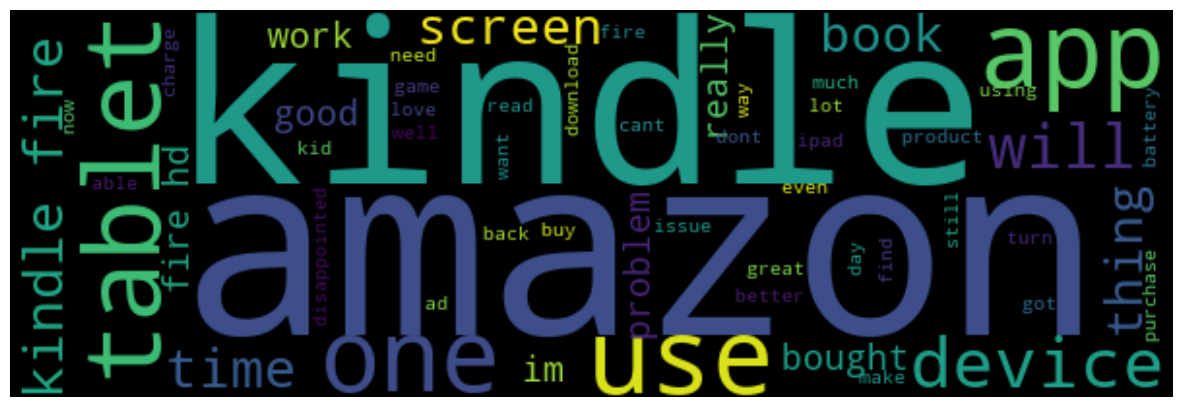

In [14]:
# create the Wordcloud of all the words with sentiment = 0 

consolidated=' '.join(word for word in df['review_body'][df['sentiment']==0].astype(str))
wordCloud=WordCloud(width=300,height=100,scale=2)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()


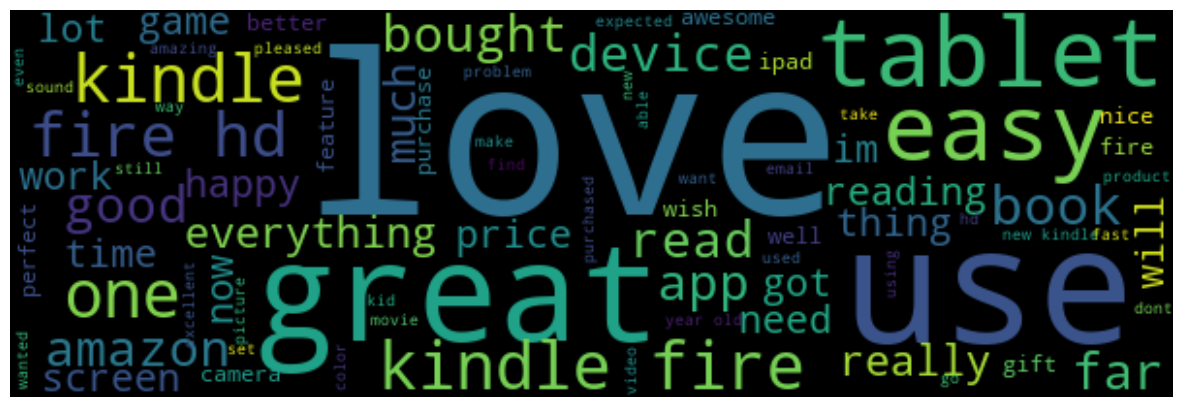

In [15]:
#create a wordcloud of all the words with sentiment 1
consolidated=' '.join(word for word in df['review_body'][df['sentiment']==1].astype(str))
wordCloud=WordCloud(width=300,height=100,scale=2)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
#import spacy library for the NLP tasks
import spacy

# Load the English model for spaCy
nlp = spacy.load('en_core_web_sm')

# Apply the spaCy pipeline to your reviews
df['reviews_text'] = df['review_body'].apply(lambda row: ' '.join([token.lemma_ for token in nlp(row)
                                                                           if not token.is_stop]))

In [17]:
from sklearn.model_selection import train_test_split

# Split the data into test and train data
x_train, x_test, y_train, y_test = train_test_split(df['reviews_text'], df['sentiment'], random_state=42, test_size=0.20)

# Print the shapes of the train and test sets
print(x_train.shape, x_test.shape, y_train.shape)


(24672,) (6168,) (24672,)


In [18]:
#For balancing the class distribution
from imblearn.over_sampling import SMOTE

In [19]:
# Define the resampling method
method = SMOTE(random_state=42)

In [20]:
# Vectorize your text data
vectorizer = TfidfVectorizer(stop_words="english")

#fit and transform the text
x = vectorizer.fit_transform(df['reviews_text'])

In [21]:
# Create the resampled feature set
x_resampled, y_resampled = method.fit_resample(x, df['sentiment'])

# Now you can split your resampled data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, random_state=42, test_size=0.20)


## Model training and evaluation

In [22]:
#call the logistic regression
model = LogisticRegression()

In [23]:
#fit the model
model.fit(x_train, y_train)

LogisticRegression()

In [24]:
#import the library for the evaluation of the classification model
from sklearn.metrics import accuracy_score

#predict the tset data
pred=model.predict(x_test)

#predict the train data
x_pred = model.predict(x_train)

#print the accuracy score for both the train and test data
print('Training accuracy:', accuracy_score(y_train, x_pred))
print('Test accuracy:', accuracy_score(y_test, pred))

Training accuracy: 0.9011644832605531
Test accuracy: 0.8882204541044052


In [25]:
#import the random forest library
from sklearn.ensemble import RandomForestClassifier

In [26]:
#call the model
model1 = RandomForestClassifier(n_estimators=100, random_state=42)

In [27]:
#fit the model
model1.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [28]:
# Make predictions on the test set
#predictions = model1.predict(x_test)

In [29]:
#make predictions on the test and train data
pred=model1.predict(x_test)

x_pred = model1.predict(x_train)

In [31]:
from sklearn.metrics import classification_report

# Assuming y_true are the true labels and y_pred are the predicted labels
accuracy = accuracy_score(y_test, pred)
report = classification_report(y_test, pred)

#print the accuracy score and classification report
print("Accuracy:", accuracy)
print("Classification Report:\n", report)


print('Training accuracy:', accuracy_score(y_train, x_pred))
print('Test accuracy:', accuracy_score(y_test, pred))


Accuracy: 0.9307199689501261
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93      5145
           1       0.97      0.89      0.93      5161

    accuracy                           0.93     10306
   macro avg       0.93      0.93      0.93     10306
weighted avg       0.93      0.93      0.93     10306

Training accuracy: 0.9940320232896652
Test accuracy: 0.9307199689501261


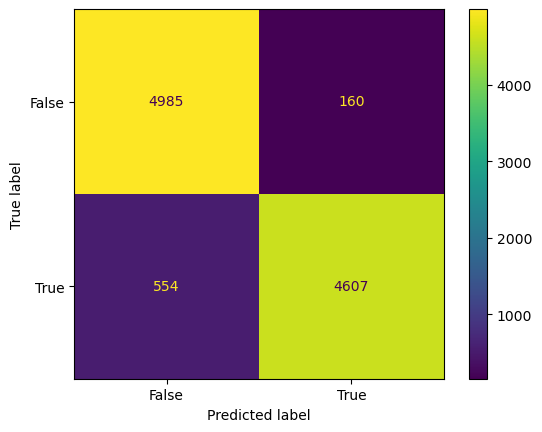

In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,pred)
 
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                            display_labels = [False, True])
 
cm_display.plot()
plt.show()

In [33]:
#import the pickle library
import pickle

In [34]:
#save the random forest model
with open('classifier.pkl', 'wb') as file:
    pickle.dump(model1, file)

In [35]:
import os

#to get the directory of the saved model
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: C:\Users\USER\Desktop


In [36]:
# Save the vectorizer to a file
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)